# MPMS rock magnetic experiments data analysis

## Import scientific python libraries

In [1]:
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import pandas as pd
import numpy as np
import scipy
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

%matplotlib inline

## Import data

In [2]:
NED2_8c_MPMS = pd.read_csv('./MPMS_data/NED2_8c_MPMS.csv')
NED2_8c_MPMS.head()

,experiment,T [K],Bapp [T],M [Am2/kg],reg fit,timestamp
0,FC,9.994304,0,0.015529,0.984894,1/8/2020 9:39:53 PM
1,FC,15.500260,0,0.014205,0.984457,1/8/2020 9:41:15 PM
2,FC,20.576900,0,0.013058,0.984438,1/8/2020 9:42:16 PM
3,FC,25.597500,0,0.012188,0.984445,1/8/2020 9:43:18 PM
4,FC,30.620950,0,0.011418,0.984483,1/8/2020 9:44:18 PM


In [3]:
def parse_MPMS_data(MPMS):
    if 'FC' in MPMS.experiment.unique():
        MPMS_FC = MPMS[MPMS.experiment == 'FC'].reset_index(drop = True)
    if 'ZFC' in MPMS.experiment.unique():   
        MPMS_ZFC = MPMS[MPMS.experiment == 'ZFC'].reset_index(drop = True)
    if 'RTSIRM_cooling' in MPMS.experiment.unique():
        MPMS_RTSIRM_cool = MPMS[MPMS.experiment == 'RTSIRM_cooling'].reset_index(drop = True)
    if 'RTSIRM_warming' in MPMS.experiment.unique():
        MPMS_RTSIRM_warm = MPMS[MPMS.experiment == 'RTSIRM_warming'].reset_index(drop = True)
    return MPMS_FC, MPMS_ZFC, MPMS_RTSIRM_cool, MPMS_RTSIRM_warm

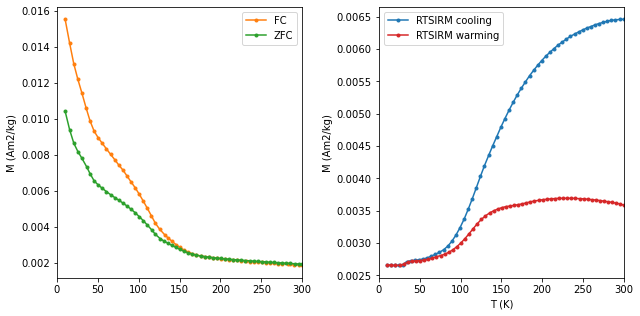

In [4]:
MPMS_file_path = './MPMS_data/NED2_8c_MPMS.csv'
MPMS_df = pd.read_csv(MPMS_file_path)
MPMS_FC, MPMS_ZFC, MPMS_RTSIRM_cool, MPMS_RTSIRM_warm = parse_MPMS_data(MPMS_df)

fig = plt.figure(figsize=(9,4.5))
ax0 = fig.add_subplot(1,2,1)
ax0.plot(MPMS_FC['T [K]'],MPMS_FC['M [Am2/kg]'],'.-',color='C1',label='FC')
ax0.plot(MPMS_ZFC['T [K]'],MPMS_ZFC['M [Am2/kg]'],'.-',color='C2',label='ZFC')
ax0.set_xlim(0,300)
ax0.set_ylabel('M (Am2/kg)')
ax0.legend()

ax1 = plt.subplot(1,2,2)
ax1.plot(MPMS_RTSIRM_cool['T [K]'],MPMS_RTSIRM_cool['M [Am2/kg]'],'.-',color='C0',label='RTSIRM cooling')
ax1.plot(MPMS_RTSIRM_warm['T [K]'],MPMS_RTSIRM_warm['M [Am2/kg]'],'.-',color='C3',label='RTSIRM warming')
ax1.set_xlim(0,300)
ax1.set_ylabel('M (Am2/kg)')
ax1.set_xlabel('T (K)')
ax1.legend()

fig.tight_layout()

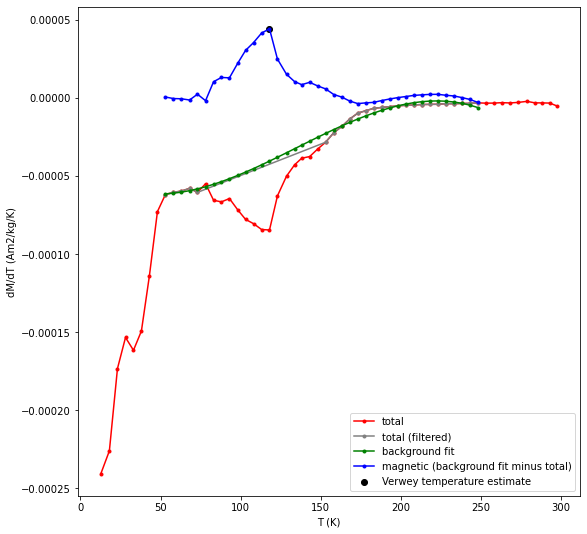

In [50]:
temps = MPMS_FC['T [K]']
mags = MPMS_FC['M [Am2/kg]']

dM = mags.diff()
dT = temps.diff()

dM_dT = dM/dT
dM_dT_real = dM_dT[1:]
dM_dT_real.reset_index(drop = True, inplace=True)

temps_dM_dT = []
for n in range(len(temps)-1):
    temps_dM_dT.append(temps[n] + dT[n+1]/2)
temps_dM_dT = pd.Series(temps_dM_dT)

dM_dT_df = pd.DataFrame({'T':temps_dM_dT,'dM_dT':dM_dT_real})
    
fig = plt.figure(figsize=(9,9))
ax0 = fig.add_subplot(1,1,1)
ax0.plot(dM_dT_df['T'],dM_dT_df['dM_dT'],'.-',color='red',label='total')

t_range_background_min = 50
t_range_background_max = 250
excluded_t_min=75
excluded_t_max = 150
poly_deg = 3

temps_filtered_indices = [i for i in np.arange(len(temps_dM_dT)) if ((float(temps_dM_dT[i]) > float(t_range_background_min)) and (float(temps_dM_dT[i])  < float(excluded_t_min)) ) or ((float(temps_dM_dT[i]) > float(excluded_t_max)) and (float(temps_dM_dT[i])  < float(t_range_background_max)))]
temps_filtered = dM_dT_df['T'][temps_filtered_indices]
dM_dT_filtered = dM_dT_df['dM_dT'][temps_filtered_indices]

ax0.plot(temps_filtered,dM_dT_filtered,'.-',color='grey',label='total (filtered)')
ax0.set_ylabel('dM/dT (Am2/kg/K)')
ax0.set_xlabel('T (K)')

poly_background_fit = np.polyfit(temps_filtered, dM_dT_filtered, poly_deg)
temps_background_indices = [i for i in np.arange(len(temps_dM_dT)) if ((float(temps_dM_dT[i]) > float(t_range_background_min)) and (float(temps_dM_dT[i])  < float(t_range_background_max)))]
temps_background = dM_dT_df['T'][temps_background_indices]
temps_background.reset_index(drop = True, inplace=True)
dM_dT_background = dM_dT_df['dM_dT'][temps_background_indices]

dM_dT_polyfit = np.poly1d(poly_background_fit)(temps_background)

mgt_dM_dT = dM_dT_polyfit - dM_dT_background 
mgt_dM_dT.reset_index(drop = True, inplace=True)

max_mgt_dM_dT = max(mgt_dM_dT)
max_mgt_dM_dT_index = mgt_dM_dT.argmax()
verwey_estimate = temps_background[max_mgt_dM_dT_index]

ax0.plot(temps_background,dM_dT_polyfit,'.-',color='green',label='background fit')
ax0.plot(temps_background,mgt_dM_dT,'.-',color='blue',label='magnetic (background fit minus total)')
ax0.scatter(verwey_estimate,max_mgt_dM_dT,color='black',label='Verwey temperature estimate')
ax0.set_ylabel('dM/dT (Am2/kg/K)')
ax0.set_xlabel('T (K)')
ax0.legend(loc='lower right')
plt.show()